In [1]:
import sys
sys.path.append('D:/Code-Templates/YOLO/yolov5/') # Give local directory to yolov5 repo here
import matplotlib.pyplot as plt
import torch
from models.common import DetectMultiBackend
import cv2
from utils.dataloaders import LoadImages
from pathlib import Path
from utils.general import non_max_suppression,Profile,scale_boxes,xyxy2xywh
from utils.plots import Annotator
import yaml

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [3]:
def get_yolo_results(image_path,model):
    source = image_path
    imgsz=(640, 640)
    stride = model.stride
    pt = model.pt
    dataset = LoadImages(source, img_size=imgsz, stride=stride, auto=pt)
    conf_thres = 0.25
    iou_thres=0.45
    classes = None
    agnostic_nms = False
    max_det = 1000
    webcam = False
    save_dir = Path('D:/Upwork/KS/MOHIT/')
    save_crop = False
    line_thickness = 3
    names = model.names

    total_detections = []
    seen, windows, dt = 0, [], (Profile(), Profile(), Profile())
    for path, im, im0s, vid_cap, s in dataset:
            with dt[0]:
                im = torch.from_numpy(im).to(model.device)
                im = im.half() if model.fp16 else im.float()  # uint8 to fp16/32
                im /= 255  # 0 - 255 to 0.0 - 1.0
                if len(im.shape) == 3:
                    im = im[None]  # expand for batch dim

            # Inference
            with dt[1]:
                visualize = False
                augment = False
                pred = model(im, augment=augment, visualize=visualize)

            # NMS
            with dt[2]:
                pred = non_max_suppression(pred, conf_thres, iou_thres, classes, agnostic_nms, max_det=max_det)
            for i, det in enumerate(pred):  # per image
                seen += 1
                if webcam:  # batch_size >= 1
                    p, im0, frame = path[i], im0s[i].copy(), dataset.count
                    s += f'{i}: '
                else:
                    p, im0, frame = path, im0s.copy(), getattr(dataset, 'frame', 0)

                p = Path(p)  # to Path
                save_path = str(save_dir / p.name)  # im.jpg
                #txt_path = str(save_dir / 'labels' / p.stem) + ('' if dataset.mode == 'image' else f'_{frame}')  # im.txt
                txt_path = str(save_dir / p.stem)
                s += '%gx%g ' % im.shape[2:]  # print string
                gn = torch.tensor(im0.shape)[[1, 0, 1, 0]]  # normalization gain whwh
                imc = im0.copy() if save_crop else im0  # for save_crop
                annotator = Annotator(im0, line_width=line_thickness, example=str(names))
                if len(det):
                    # Rescale boxes from img_size to im0 size
                    det[:, :4] = scale_boxes(im.shape[2:], det[:, :4], im0.shape).round()

                    # Print results
                    for c in det[:, 5].unique():
                        n = (det[:, 5] == c).sum()  # detections per class
                        s += f"{n} {names[int(c)]}{'s' * (n > 1)}, "  # add to string

                    # Write results
                    save_conf = True
                    for *xyxy, conf, cls in reversed(det):
                            xywh = (xyxy2xywh(torch.tensor(xyxy).view(1, 4)) / gn).view(-1).tolist()  # normalized xywh
                            line = (cls, *xywh, conf) if save_conf else (cls, *xywh)  # label format
    #                         with open(f'{txt_path}.txt', 'a') as f:
    #                             f.write(('%g ' * len(line)).rstrip() % line + '\n')
                            total_detections.append(line)
        
    converted_detections = [tuple(value.item() if isinstance(value, torch.Tensor) else value for value in item) for item in total_detections]
        
    return converted_detections

In [4]:
weights = 'D:/Code-Templates/YOLO/yolov5/runs/train/results_1/weights/best.pt' # Path to model weights
dnn= False
fp16=False 
data = 'D:/Code-Templates/YOLO/dataset/data.yaml' #  Path to data.yaml
model = DetectMultiBackend(weights, device=device, dnn=dnn, data=data, fp16=fp16)
imgsz=(640, 640)
pt = model.pt
model.warmup(imgsz=(1 if pt or model.triton else bs, 3, *imgsz))

Fusing layers... 
Model summary: 157 layers, 7015519 parameters, 0 gradients, 15.8 GFLOPs


In [5]:
def get_bboxes(image_path, detections):
    image = cv2.imread(image_path)
    
    bounding_boxes = []
    
    for cls, x, y, w, h, confidence in detections:
        cls = int(cls)
        left = int((x - w/2) * image.shape[1]) - 10
        top = int((y - h/2) * image.shape[0]) - 10
        width = int(w * image.shape[1]) + 20
        height = int(h * image.shape[0]) + 20
        
        bounding_boxes.append({
            'class': cls,
            'left': left,
            'top': top,
            'width': width,
            'height': height,
            'confidence':confidence
        })
    
    return bounding_boxes

In [6]:
def get_highest_confidence_detections(detections):
    # Initialize dictionaries to store the highest confidence detections for each class
    highest_confidence_detections = {}
    
    # Iterate through the detections
    for detection in detections:
        class_id = detection['class']
        confidence = detection['confidence']
        
        # Check if the class_id is already in the highest_confidence_detections dictionary
        if class_id not in highest_confidence_detections:
            highest_confidence_detections[class_id] = {'detection': detection, 'confidence': confidence}
        else:
            # Update the detection with higher confidence if found
            if confidence > highest_confidence_detections[class_id]['confidence']:
                highest_confidence_detections[class_id] = {'detection': detection, 'confidence': confidence}
    
    # Convert the result back to a list
    result = [value['detection'] for value in highest_confidence_detections.values()]
    
    return result

In [7]:
def draw_detections(image_path, detections, class_names):
    # Load the input image
    image = cv2.imread(image_path)
    
    # Loop through each detection and draw rectangles and labels
    for detection in detections:
        class_id = detection['class']
        label = class_names[class_id]
        left = detection['left']
        top = detection['top']
        width = detection['width']
        height = detection['height']
        confidence = detection['confidence']
        
        # Draw rectangle
        cv2.rectangle(image, (left, top), (left + width, top + height), (0, 255, 0), 2)
        
        # Add the label with class name and confidence
        font_scale = 1.0  # Adjust this value to increase/decrease font size
        font_thickness = 5  # Font thickness
        font = cv2.FONT_HERSHEY_SIMPLEX
        label_text = f'{label}, Confidence: {confidence:.2f}'
        cv2.putText(image, label_text, (left, top - 10), font, font_scale, (0, 255, 0), font_thickness)
    
    return image

In [8]:
def load_class_names(data_file):
    with open(data_file, 'r') as file:
        data = yaml.safe_load(file)
    return data['names']

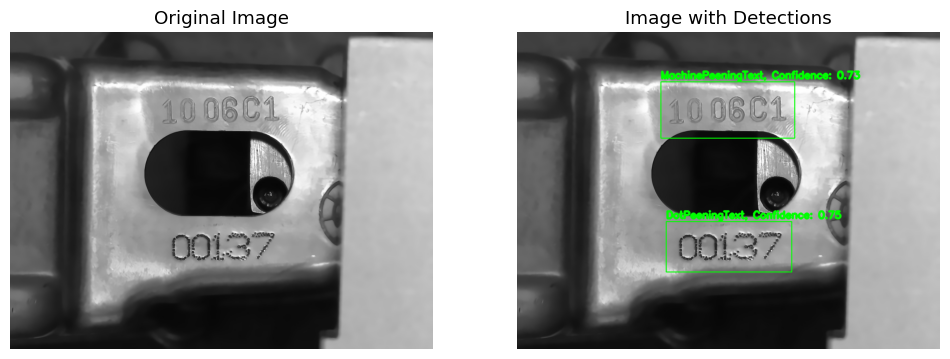

In [9]:
%matplotlib notebook
%matplotlib inline

image_path_1 = 'D:/Code-Templates/YOLO/check.jpg'
original_image = cv2.imread(image_path_1)
# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Plot the original image in the first subplot
axs[0].imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))
axs[0].set_title('Original Image')
axs[0].axis('off')  # Turn off axis labels for the first subplot

class_names = load_class_names(data)
detections = get_bboxes(image_path_1, get_yolo_results(image_path_1, model))
detections = get_highest_confidence_detections(detections)
image_with_detections = draw_detections(image_path_1, detections,class_names)

# Plot the marked image in the second subplot
axs[1].imshow(cv2.cvtColor(image_with_detections, cv2.COLOR_BGR2RGB))
axs[1].set_title('Image with Detections')
axs[1].axis('off')  # Turn off axis labels for the second subplot

# Display the subplots
plt.show()